**Import**




In [1]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz
import os
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import seaborn as sn
import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.preprocessing import LabelEncoder


from seaborn import heatmap
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score

!pip install 'neptune-contrib[monitoring]>=0.24.9'
import neptune

from neptunecontrib.monitoring.xgboost_monitor import neptune_callback
neptune.init('shared/XGBoost-integration',
             api_token='ANONYMOUS')


/usr/local/lib/python3.7/dist-packages/neptunecontrib/monitoring/xgboost_monitor.py:21: UserWarning: neptunecontrib.monitoring.xgboost_monitor was moved to neptunecontrib.monitoring.xgboost
neptunecontrib.monitoring.xgboost_monitor will be removed in future releases.

  warnings.warn(message)


Project(shared/XGBoost-integration)

**Download NLTK packages**




In [2]:
string.punctuation
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**Datasets**

In [37]:
dataset1 = pd.read_csv("/content/COVIDdata1.csv", delimiter=',')
dataset2 = pd.read_csv("/content/COVIDdata2.csv", delimiter=',')
rumor_df = pd.concat([dataset1, dataset2])
pd.set_option('display.max_colwidth' , 300)
print(rumor_df.shape)
rumor_df.head()

(8560, 3)


id  ... label
0   1  ...  real
1   2  ...  fake
2   3  ...  fake
3   4  ...  real
4   5  ...  real

[5 rows x 3 columns]

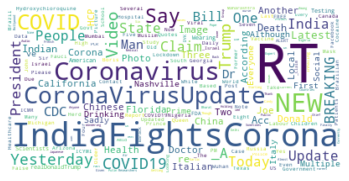

In [ ]:
from wordcloud import WordCloud

#Checking for NaN values
rumor_df.isna().sum()
#Removing NaN Values
#df.dropna(inplace = True)
#Creating the text variable
text = " ".join(cat.split()[0] for cat in rumor_df.tweet)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
rumor_df.label.unique()

array(['real', 'fake'], dtype=object)

**Applying NLP text preprocessing techniques to clean the tweets**

In [38]:
def clean_text(txt):
  remove_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  txt = remove_pattern.sub('', str(txt))
  txt = "".join([c for c in txt if c not in string.punctuation])
  remove_emoji = re.compile("["
                    u"\U0001F600-\U0001FFFF"  # emoticons
                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    "]+", flags=re.UNICODE)
  txt = remove_emoji.sub(r'', txt)
  tokens = word_tokenize(txt.lower())
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalpha()]
  txt = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]
  return txt

rumor_df['cleantweet'] = rumor_df['tweet'].apply(lambda x: clean_text(x))

# rumor_df=rumor_df.replace(to_replace="real",value="1")
# rumor_df=rumor_df.replace(to_replace="fake",value="0")

# mapping = {'real': 1, 'false': 2}
# rumor_df.replace({'real': mapping, 'false': mapping})

fakeOrreal = {'fake' : 0 , 'real' : 1 }
rumor_df['label'] = rumor_df['label'].map(fakeOrreal)
rumor_df.head()

id  ...                                                                                                                                                                                                                       cleantweet
0   1  ...                                                                           [daily, update, published, state, reported, 734k, test, 39k, new, case, 532, death, current, hospitalization, fell, 30k, first, time, since, june, 22]
1   2  ...                                                                                                                                                                                                         [alfalfa, cure, covid19]
2   3  ...                                                                                                                                                   [president, trump, asked, would, catch, coronavirus, donaldtrump, coronavirus]
3   4  ...  [state, reported, 630, death, still, seeing, solid, national, decline, death, reporting, lag, approximately, 28, day, symptom, onset, according, cdc, model, consider, lag, symptom, time, hospital, death, reporting, process]
4   5  ...                                                                                                                    [sixth, time, global, health, emergency, declared, international, health, regulation, easily, severedrtedros]

[5 rows x 4 columns]

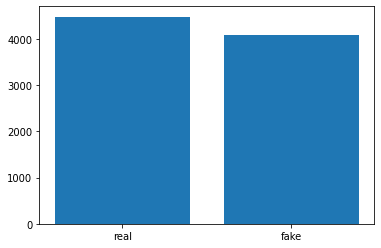

In [ ]:

classes = rumor_df.label.unique()
counts = []

for i in classes:
  count = len(rumor_df[rumor_df.label==i])
  counts.append(count)

plt.bar(['real', 'fake'], counts)
plt.show()



**TF-IDF Vectorization**

In [39]:
 
# Vectorizer1 = TfidfVectorizer(analyzer=clean_text)
# tfidf = Vectorizer1.fit_transform(rumor_df['cleantweet'])
# print(tfidf.shape)
# df = pd.DataFrame(tfidf.toarray(), columns = Vectorizer1.get_feature_names())
# df.head(20)
def tfidfvec(data, ngrams=(1,1)):
  Vectorizer1 = TfidfVectorizer(ngram_range=ngrams, analyzer=clean_text)
  tfidf = Vectorizer1.fit_transform(data)
  return tfidf, Vectorizer1
tfidf, Vectorizer1  = tfidfvec(rumor_df['cleantweet'])


In [40]:
[x for x in tfidf.todense()[0][0:].tolist()[0] if x!= 0]

[0.25301081641663975,
 0.30587847764094184,
 0.3287592441064324,
 0.33744555121540853,
 0.3644276855706449,
 0.10344500545257618,
 0.21624576746625637,
 0.1691200763765954,
 0.12971806753532517,
 0.2767916690268411,
 0.18401162997982798,
 0.20046223067902302,
 0.21939764946934848,
 0.1148668637226982,
 0.1871589588521556,
 0.15028025437161066,
 0.1816294709003688,
 0.12463150487944978,
 0.1270042866291776,
 0.16293574930639612,
 0.15482549242327215]

In [41]:
tfidf, Vectorizer1 = tfidfvec(rumor_df['cleantweet']) 

In [42]:
tfidf, Vectorizer1 = tfidfvec(rumor_df['cleantweet'], ngrams=(1,2))  
print(tfidf.todense()[0][0:].sum())

4.29204645202099


In [43]:
Vectorizer1.get_feature_names()

['0',
 '000',
 '003',
 '0054',
 '006',
 '01',
 '01072020',
 '011',
 '014',
 '014122256242225000',
 '02',
 '027',
 '029',
 '02april2020',
 '03',
 '033',
 '03323412600',
 '04',
 '0400',
 '0408',
 '041461636',
 '047738491',
 '048831145',
 '05',
 '0528',
 '06',
 '06243222835',
 '062454254',
 '0625',
 '06254246144',
 '063661060',
 '0645am',
 '06512490104',
 '07',
 '0700',
 '0710',
 '075',
 '079',
 '08',
 '0800',
 '0805',
 '085',
 '0881911',
 '09',
 '0900',
 '0900pm',
 '0910',
 '0930',
 '093020408',
 '0940',
 '0945',
 '0950',
 '0…',
 '1',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '10001100000',
 '1000190000',
 '1000bed',
 '1000th',
 '1002',
 '1003',
 '1003299',
 '1006615',
 '1007',
 '1008',
 '1009976',
 '100b',
 '100bed',
 '100k',
 '100m',
 '101',
 '1010',
 '1010824',
 '1011',
 '1012',
 '1013',
 '1013964',
 '1013refund',
 '1014',
 '1015',
 '10152',
 '10162',
 '1016920',
 '1017754',
 '1019',
 '101951',
 '102',
 '1023',
 '10238',
 '1024',
 '1027',
 '102k',
 '103',
 '1030',
 '1031',
 '10315

**Count Vectorization**

**Train-test split**

In [44]:
data = rumor_df["cleantweet"]
label = rumor_df["label"]
# label = pd.factorize(rumor_df['label'])[0].reshape(-1, 1) 
[data_train, data_test, label_train, label_test] = train_test_split(tfidf, label, test_size=0.25, random_state=2, stratify=label)

**Feature Scaling**

In [45]:
from sklearn. preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
data_train = sc.fit_transform(data_train)
data_test = sc.transform(data_test)

**XGBoost**

In [46]:
from xgboost import XGBClassifier

#3m 43s
# fit model 
xgb_model = XGBClassifier(learning_rate=0.15, max_depth=8, n_estimators=300, nthread=-1, silent=True, subsample=0.9)
xgb_model.fit(data_train, label_train)

# make predictions for test data
label_pred1 = xgb_model.predict(data_test)
xgb_predictions = [round(value) for value in label_pred1]

**Accuracy, recall, precision, F1 scores for XGB**

In [23]:
#evaluate predictions

#accuracy
xgb_accuracy = accuracy_score(label_test, xgb_predictions)
print("Accuracy using XGBoost: %.2f%%" % (xgb_accuracy * 100.0))

#recall
from sklearn.metrics import recall_score
xgb_recall = recall_score(label_test, xgb_predictions)
print("Recall for XGB: ", xgb_recall)

#precision
from sklearn.metrics import precision_score
xgb_precision = precision_score(label_test, xgb_predictions, average=None)
print("Precision for XGB: ", xgb_precision)

#F1 Score
from sklearn.metrics import f1_score
xgb_f1score = f1_score(label_test, xgb_predictions, average=None)
print("F1 Score for XGB: ", xgb_f1score)

#manual f1 score
xgb_F1 = 2* (xgb_precision * xgb_recall) / (xgb_precision + xgb_recall)
print("Manual F1 score for XGB: ", xgb_F1)

Accuracy using XGBoost: 90.23%
Recall for XGB:  0.8785714285714286
Precision for XGB:  [0.8744229  0.93093661]
F1 Score for XGB:  [0.90061816 0.90399633]
Manual F1 score for XGB:  [0.87649226 0.90399633]


**Confusion matrix for XGB**

Confusion Matrix for XGBoost: 
 [[947  73]
 [136 984]]


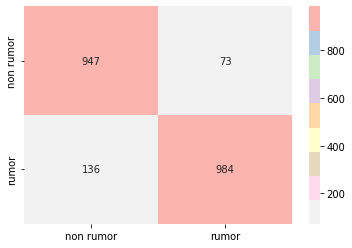

In [24]:
xgb_conmat = confusion_matrix(label_test, xgb_predictions)
print("Confusion Matrix for XGBoost: " + "\n" , xgb_conmat)

heatmap(xgb_conmat , cmap="Pastel1_r", xticklabels=['non rumor' ,'rumor'], yticklabels=['non rumor' ,'rumor'], annot=True, fmt='g')

**Explainability (LIME) for XGB**

In [25]:
!pip install lime

     |████████████████████████████████| 275 kB 13.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=fec2716e98163e685ba985b7d6d363e740d7caefa6a098a0a0beb8182e4e063e
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [58]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(Vectorizer1, xgb_model)
rumor_df.tweet.iloc[8000]


"In case you're going to worst case scenarios regarding this COVID-19 stuff, just remember. The death rate of Chicago has actually lowered since the outbreak started."

In [60]:
print(pipe.predict_proba([rumor_df.tweet.iloc[8000]]))

[[0.66350484 0.33649513]]


In [71]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["non rumor", "rumor"])
max_features = rumor_df.tweet.str.split().map(lambda x: len(x)).max() 
print("Maximum number of features: ", max_features)
import random
random.seed(20)
idx = random.randint(0, len(rumor_df))
exp1 = explainer.explain_instance(
    rumor_df.tweet.iloc[idx], pipe.predict_proba, num_features=7
    
)
print(f"Explanation as a list of weighted features: ")
exp1.as_list()


Maximum number of features:  1484
Explanation as a list of weighted features: 


[('COVID', -0.12945349005940351),
 ('COVID19', 0.08378332219664611),
 ('current', 0.0814033830690975),
 ('per', 0.07442572853692189),
 ('transmission', 0.04941574798129624),
 ('symptoms', 0.04808242205917741),
 ('remain', 0.044422843783790716)]

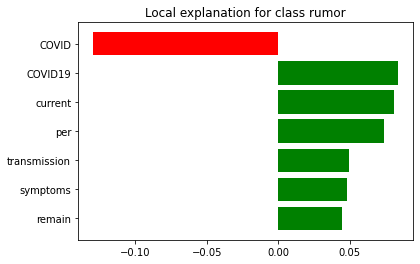

In [72]:
plot = exp1.as_pyplot_figure()

In [ ]:
exp1.show_in_notebook(text=False)

**Support Vector Machine**

In [ ]:
from sklearn.svm import SVC

#11m 35s
# fit model 
svc = SVC(kernel="linear", C=1.0, random_state=27,probability=True)
svc.fit(data_train, label_train)

# make predictions for test data 
label_pred2 = svc.predict(data_test)
svc_predictions = [round(value) for value in label_pred2]

**Accuracy, recall, precision, F1 scores for SVM**

In [ ]:
#evaluate predictions

#accuracy
svc_accuracy = accuracy_score(label_test, svc_predictions)
print("Accuracy using Support Vector Machine: %.2f%%" % (svc_accuracy * 100.0))

#recall
from sklearn.metrics import recall_score
svc_recall = recall_score(label_test, svc_predictions)
print("Recall for SVM: ", svc_recall)

#precision
from sklearn.metrics import precision_score
svc_precision = precision_score(label_test, svc_predictions, average=None)
print("Precision for SVM: ", svc_precision)

#F1 Score
from sklearn.metrics import f1_score
svc_f1score = f1_score(label_test, svc_predictions, average=None)
print("F1 Score for SVM: ", svc_f1score)

#manual f1 score
svc_F1 = 2* (svc_precision * svc_recall) / (svc_precision + svc_recall)
print("Manual F1 score for SVM: ", svc_F1)

Accuracy using Support Vector Machine: 90.05%
Recall for SVM:  0.8830357142857143
Precision for SVM:  [0.87745557 0.92343604]
F1 Score for SVM:  [0.89803734 0.90278412]
Manual F1 score for SVM:  [0.8802368  0.90278412]


**Confusion matrix for SVM**

Confusion Matrix for Support Vector Machine: 
 [[938  82]
 [131 989]]


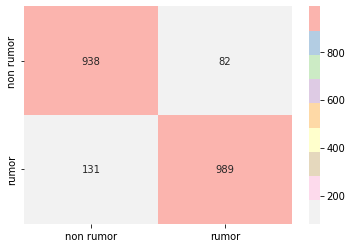

In [ ]:
svc_conmat = confusion_matrix(label_test, svc_predictions)
print("Confusion Matrix for Support Vector Machine: " + "\n", svc_conmat)

heatmap(svc_conmat , cmap="Pastel1_r", xticklabels=['non rumor' ,'rumor'], yticklabels=['non rumor' ,'rumor'], annot=True, fmt='g')

In [36]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(Vectorizer1, svc)
data.iloc[0]
print(pipe.predict_proba([rumor_df.tweet.iloc[0]]))

NameError: ignored

[[0.72576002 0.27423998]]
Maximum number of features:  1484
Explanation as a list of weighted features: 


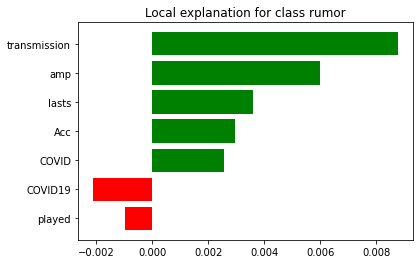

In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(Vectorizer1, svc)
rumor_df.tweet.iloc[0]
print(pipe.predict_proba([rumor_df.tweet.iloc[0]]))
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["non rumor", "rumor"])
max_features = rumor_df.tweet.str.split().map(lambda x: len(x)).max() 
print("Maximum number of features: ", max_features)
import random
random.seed(20)
idx = random.randint(0, len(rumor_df))
exp2 = explainer.explain_instance(
    rumor_df.tweet.iloc[idx], pipe.predict_proba, num_features=7
    
)
print(f"Explanation as a list of weighted features: ")
exp2.as_list()
plot = exp2.as_pyplot_figure()

In [ ]:
exp2.show_in_notebook(text=False)

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 300, max_depth = 300, random_state = 27)
rf.fit(data_train,label_train)
label_pred1 = rf.predict(data_test)
rf_predictions = [round(value) for value in label_pred1]

**Accuracy, recall, precision, F1 scores for RFC**

In [ ]:
#evaluate predictions

#accuracy
rf_accuracy = accuracy_score(label_test, rf_predictions)
print("Accuracy using RF: %.2f%%" % (rf_accuracy * 100.0))

#recall
from sklearn.metrics import recall_score
rf_recall = recall_score(label_test, rf_predictions)
print("Recall for RF: ", rf_recall)

#precision
from sklearn.metrics import precision_score
rf_precision = precision_score(label_test, rf_predictions, average=None)
print("Precision for RF: ", rf_precision)

#F1 Score
from sklearn.metrics import f1_score
rf_f1score = f1_score(label_test, rf_predictions, average=None)
print("F1 Score for RF: ", rf_f1score)

#manual f1 score
rf_F1 = 2* (rf_precision * rf_recall) / (rf_precision + rf_recall)
print("Manual F1 score for RF: ", rf_F1)

Accuracy using RF: 91.64%
Recall for RF:  0.8901785714285714
Precision for RF:  [0.88684453 0.94681861]
F1 Score for RF:  [0.91504509 0.9176254 ]
Manual F1 score for RF:  [0.88850842 0.9176254 ]


**Confusion Matrix for RFC**

Confusion Matrix for Random Forest: 
 [[964  56]
 [123 997]]


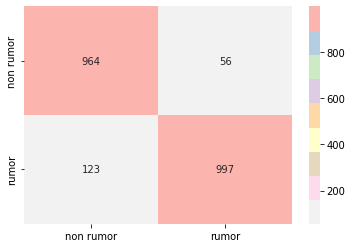

In [ ]:
rf_conmat = confusion_matrix(label_test, rf_predictions)
print("Confusion Matrix for Random Forest: " + "\n" , rf_conmat)

heatmap(rf_conmat , cmap="Pastel1_r", xticklabels=['non rumor' ,'rumor'], yticklabels=['non rumor' ,'rumor'], annot=True, fmt='g')

[[0.97835967 0.02164033]]
Maximum number of features:  1484
Explanation as a list of weighted features: 


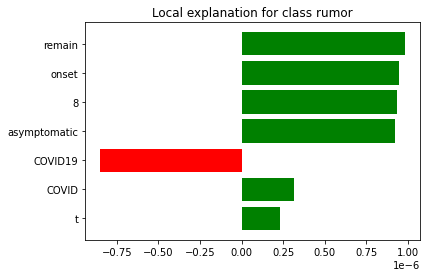

In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(Vectorizer1, rf)
rumor_df.tweet.iloc[0]
print(pipe.predict_proba([rumor_df.tweet.iloc[0]]))
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["non rumor", "rumor"])
max_features = rumor_df.tweet.str.split().map(lambda x: len(x)).max() 
print("Maximum number of features: ", max_features)
import random
random.seed(20)
idx = random.randint(0, len(rumor_df))
exp3 = explainer.explain_instance(
    rumor_df.tweet.iloc[idx], pipe.predict_proba, num_features=7
    
)
print(f"Explanation as a list of weighted features: ")
exp3.as_list()
plot = exp3.as_pyplot_figure()

In [ ]:
exp3.show_in_notebook(text=False)

**Extra Trees Classifier**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators = 300, max_depth = 300, random_state = 27)
etc.fit(data_train,label_train)
label_pred1 = etc.predict(data_test)
etc_predictions = [round(value) for value in label_pred1]

**Accuracy, recall, precision, F1 scores for ETC**

In [ ]:
#evaluate predictions

#accuracy
etc_accuracy = accuracy_score(label_test, etc_predictions)
print("Accuracy using ETC: %.2f%%" % (etc_accuracy * 100.0))

#recall
from sklearn.metrics import recall_score
etc_recall = recall_score(label_test, etc_predictions)
print("Recall for ETC: ", etc_recall)

#precision
from sklearn.metrics import precision_score
etc_precision = precision_score(label_test, etc_predictions, average=None)
print("Precision for ETC: ", etc_precision)

#F1 Score
from sklearn.metrics import f1_score
etc_f1score = f1_score(label_test, etc_predictions, average=None)
print("F1 Score for ETC: ", rf_f1score)

#manual f1 score
etc_F1 = 2* (etc_precision * etc_recall) / (etc_precision + etc_recall)
print("Manual F1 score for ETC: ", etc_F1)

Accuracy using ETC: 92.90%
Recall for ETC:  0.9125
Precision for ETC:  [0.90789474 0.94981413]
F1 Score for ETC:  [0.91504509 0.9176254 ]
Manual F1 score for ETC:  [0.91019154 0.93078324]


**Confusion Matrix for ETC**

Confusion Matrix for Extra Trees Classifer: 
 [[ 966   54]
 [  98 1022]]


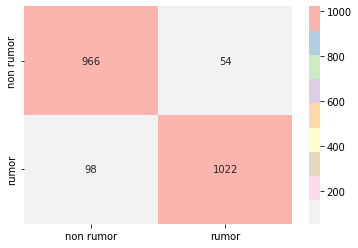

In [ ]:
etc_conmat = confusion_matrix(label_test, etc_predictions)
print("Confusion Matrix for Extra Trees Classifer: " + "\n" , etc_conmat)

heatmap(etc_conmat , cmap="Pastel1_r", xticklabels=['non rumor' ,'rumor'], yticklabels=['non rumor' ,'rumor'], annot=True, fmt='g')

[[0.83609803 0.16390197]]
Maximum number of features:  1484
Explanation as a list of weighted features: 


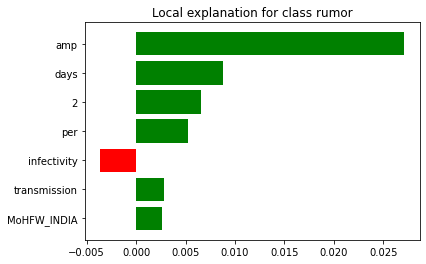

In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(Vectorizer1, etc)
rumor_df.tweet.iloc[0]
print(pipe.predict_proba([rumor_df.tweet.iloc[0]]))
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["non rumor", "rumor"])
max_features = rumor_df.tweet.str.split().map(lambda x: len(x)).max() 
print("Maximum number of features: ", max_features)
import random
random.seed(20)
idx = random.randint(0, len(rumor_df))
exp4 = explainer.explain_instance(
    rumor_df.tweet.iloc[idx], pipe.predict_proba, num_features=7
    
)
print(f"Explanation as a list of weighted features: ")
exp4.as_list()
plot = exp4.as_pyplot_figure()


In [ ]:
exp4.show_in_notebook(text=False)

**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier( max_depth = 300, criterion = 'gini')
dt.fit(data_train,label_train)
label_pred1 = dt.predict(data_test)
dt_predictions = [round(value) for value in label_pred1]


**Accuracy, recall, precision, F1 scores for DTC**

In [ ]:
#evaluate predictions

#accuracy
dt_accuracy = accuracy_score(label_test, dt_predictions)
print("Accuracy using DT: %.2f%%" % (dt_accuracy * 100.0))

#recall
from sklearn.metrics import recall_score
dt_recall = recall_score(label_test, dt_predictions)
print("Recall for DT: ", dt_recall)

#precision
from sklearn.metrics import precision_score
dt_precision = precision_score(label_test, dt_predictions, average=None)
print("Precision for DT: ", dt_precision)

#F1 Score
from sklearn.metrics import f1_score
dt_f1score = f1_score(label_test, dt_predictions, average=None)
print("F1 Score for DT: ", dt_f1score)

#manual f1 score
dt_F1 = 2* (dt_precision * dt_recall) / (dt_precision + dt_recall)
print("Manual F1 score for DT: ", dt_F1)

Accuracy using DT: 84.77%
Recall for DT:  0.8607142857142858
Precision for DT:  [0.84493042 0.85008818]
F1 Score for DT:  [0.83909181 0.85536823]
Manual F1 score for DT:  [0.85274932 0.85536823]


**Confusion Matrix for DTC**

Confusion Matrix for Decision Tree: 
 [[850 170]
 [156 964]]


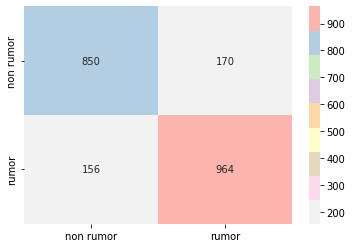

In [ ]:
dt_conmat = confusion_matrix(label_test, dt_predictions)
print("Confusion Matrix for Decision Tree: " + "\n" , dt_conmat)

heatmap(dt_conmat , cmap="Pastel1_r", xticklabels=['non rumor' ,'rumor'], yticklabels=['non rumor' ,'rumor'], annot=True, fmt='g')

[[1. 0.]]
Maximum number of features:  1484
Explanation as a list of weighted features: 


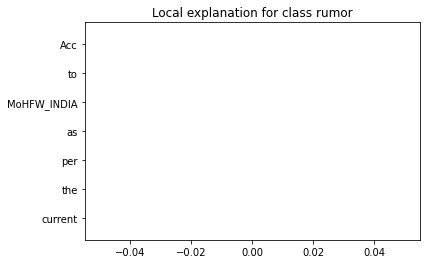

In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(Vectorizer1, dt)
rumor_df.tweet.iloc[0]
print(pipe.predict_proba([rumor_df.tweet.iloc[0]]))
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["non rumor", "rumor"])
max_features = rumor_df.tweet.str.split().map(lambda x: len(x)).max() 
print("Maximum number of features: ", max_features)
import random
random.seed(20)
idx = random.randint(0, len(rumor_df))
exp5 = explainer.explain_instance(
    rumor_df.tweet.iloc[idx], pipe.predict_proba, num_features=7
    
)
print(f"Explanation as a list of weighted features: ")
exp5.as_list()
plot = exp5.as_pyplot_figure()

In [ ]:
exp5.show_in_notebook(text=False)

**Classification reports**

In [ ]:
from sklearn.metrics import classification_report
print("Classification report for XGBoost: " + "\n" , classification_report(label_test, xgb_predictions))
print("Classification report for SVM: " + "\n", classification_report(label_test, svc_predictions))
print("Classification report for Random Forest: " + "\n" , classification_report(label_test, rf_predictions))
print("Classification report for Extra Trees Classifer: " + "\n" , classification_report(label_test, etc_predictions))
print("Classification report for Decision Tree: " + "\n" , classification_report(label_test, dt_predictions))

Classification report for XGBoost: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      1020
           1       0.93      0.88      0.90      1120

    accuracy                           0.90      2140
   macro avg       0.90      0.90      0.90      2140
weighted avg       0.90      0.90      0.90      2140

Classification report for SVM: 
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      1020
           1       0.92      0.88      0.90      1120

    accuracy                           0.90      2140
   macro avg       0.90      0.90      0.90      2140
weighted avg       0.90      0.90      0.90      2140

Classification report for Random Forest: 
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      1020
           1       0.95      0.89      0.92      1120

    accuracy                           0.92      2140
   macro avg   

**Hybrid Ensemble**

**XGB vs. Svm**

In [ ]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
SVM = [0.93, 0.93, 0.94, 0.94]
XGB = [0.86, 0.86, 0.86, 0.86,]
RFC = []
ETC = []
DTC = []
 
# Set position of bar on X axis
br1 = np.arange(len(SVM))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4] 
br6 = [x + barWidth for x in br5]
 
# Make the plot
plt.bar(br1, SVM, color ='r', width = barWidth,
        edgecolor ='grey', label ='SVM')
plt.bar(br2, XGB, color ='g', width = barWidth,
        edgecolor ='grey', label ='XGBOOST')
#plt.bar(br3, CSE, color ='b', width = barWidth,
        #edgecolor ='grey', label ='CSE')
 
# Adding Xticks
plt.xlabel('Metrics', fontweight ='bold', fontsize = 15)
plt.ylabel('Model Evaluation', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(SVM))],
        ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
 
plt.legend()
plt.show()